# Model Evaluations 

### Additional model evaluations

In [1]:
# import libraries
import numpy as np
import os 
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model, load_model 
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, GlobalMaxPooling2D, AveragePooling2D,Dropout, BatchNormalization, Activation

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Generate Model Summaries

#### RestNet50 Baseline

In [2]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Xception

In [6]:
# Encoder: The pretrained model
xception_encoder = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(229,229,3)
)

# Freeze all the encoder layers
for layer in xception_encoder.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(xception_encoder.output)  # Global average pooling 

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(1024, activation=None)(x)               # Linear transformation 1024 dimension
x = BatchNormalization()(x)                       # Normalize activations for training stability
x = Activation('relu')(x)                         # ReLU activation applied after normalization
x = Dropout(0.50)(x)                              # Dropout to random disable neurons during traing 

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(512, activation=None)(x)                # Linear transformation 512 dimension
x = BatchNormalization()(x)                       # Normalize activations for training stability
x = Activation('relu')(x)                         # ReLU activation applied after normalization
x = Dropout(0.50)(x)                              # Dropout to random disable neurons during traing 

# Fully connected layer
xception_decoder = Dense(120, activation="softmax")(x)  

# Specify model
xception_model = Model(inputs=xception_encoder.input, outputs=xception_decoder)

# Scheduler (OneCycle)

# Compile
xception_model.compile(
    optimizer = SGD(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [7]:
xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

# Misclassification Statistics

### ResNet50 (Experiment 4)

In [8]:
# Directory path of Stanford dataset images
ds_path = 'data/Images'  #unbalanced

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})

# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [13]:
model  = load_model("models/resnet50_exp4.h5")

#### Total Misclassifications

In [14]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

65/65 [==============================] - 5s 65ms/step


In [15]:
# Misclassification counts: Reesnet vs. fusion model
preds_res = model.predict(test_generator, verbose=1)
resnet_mis = np.sum(y_true != np.argmax(preds_res, axis=1))

print(f"Total misclassifications (ResNet (exp4)): {resnet_mis}")


65/65 [==============================] - 4s 59ms/step
Total misclassifications (ResNet (exp4)): 411


#### Misclassifications for Weak Classes

In [73]:


# Compute precision, recall, F1 score. ((Using macro)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Arrange by dog breed with struggles
class_report_3 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict

# Convert to dataframe (trnapose and sort)
class_report_df_3 = pd.DataFrame(class_report_3).transpose()  #transpose
class_report_df_3= class_report_df_3.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_3 = class_report_df_3.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_3 = class_report_df_3[(class_report_df_3['f1-score'] <= 0.70)]

In [74]:
# Weak class list (ResNet ≤ 0.70 F1)
class_issues_lst_3 = class_issues_df_3.index.tolist()
class_issues_norm = [c.strip().lower() for c in class_issues_lst_3]

# Map class names (breeds)
breed_name_mapping = {val: breed for breed, val in test_generator.class_indices.items()}

# Normalize names
y_true_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_true])
y_pred_res_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_classes])

# Filter: only samples whose true class is in weak list
mask = y_true_map_norm.isin(class_issues_norm)
y_true_issue = y_true_map_norm[mask].reset_index(drop=True)
y_pred_res_issue = y_pred_res_map_norm[mask].reset_index(drop=True)

# Misclassification totals (weak classes only)
resnet_mis = np.sum(y_true_issue != y_pred_res_issue)
print(f"Total misclassifications (ResNet weak classes ≤0.70 F1): {resnet_mis}")


Total misclassifications (ResNet weak classes ≤0.70 F1): 130


### ResNet50 (Experiment 6)

In [18]:
# Directory path of Stanford dataset images cropped based on the XML annotions coordinates
ds_path = "data/Images_crop"

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})


# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [19]:
#reload model in newest run to evaluate more
resnet_exp6 = load_model("models/resnet50_best.h5")
fusion_model = load_model("models/fusion_res_xcept_best.h5")

#### Total Misclassifications

In [20]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = resnet_exp6.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = resnet_exp6.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using macro)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Arrange by dog breed with struggles
class_report_3 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict


65/65 [==============================] - 4s 59ms/step


In [21]:
# Misclassification counts: Reesnet vs. fusion model
preds_res_exp6 = resnet_exp6.predict(test_generator, verbose=1)
resnet_mis_exp6 = np.sum(y_true != np.argmax(preds_res_exp6, axis=1))

print(f"Total misclassifications (ResNet (exp6)): {resnet_mis_exp6}")


65/65 [==============================] - 4s 57ms/step
Total misclassifications (ResNet (exp6)): 321


#### Misclassifications for Weak Classes

In [22]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = resnet_exp6.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = resnet_exp6.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using macro)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Arrange by dog breed with struggles
class_report_3 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict

# Convert to dataframe (trnapose and sort)
class_report_df_3 = pd.DataFrame(class_report_3).transpose()  #transpose
class_report_df_3= class_report_df_3.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_3 = class_report_df_3.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_3 = class_report_df_3[(class_report_df_3['f1-score'] <= 0.70)]

65/65 [==============================] - 4s 59ms/step


In [23]:
# Weak class list (ResNet ≤ 0.70 F1)
class_issues_lst_3 = class_issues_df_3.index.tolist()
class_issues_norm = [c.strip().lower() for c in class_issues_lst_3]

# Map class names (breeds)
breed_name_mapping = {val: breed for breed, val in test_generator.class_indices.items()}

# Normalize names
y_true_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_true])
y_pred_res_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_classes])

# Filter: only samples whose true class is in weak list
mask = y_true_map_norm.isin(class_issues_norm)
y_true_issue = y_true_map_norm[mask].reset_index(drop=True)
y_pred_res_issue = y_pred_res_map_norm[mask].reset_index(drop=True)

# Misclassification totals (weak classes only)
resnet_mis = np.sum(y_true_issue != y_pred_res_issue)
print(f"Total misclassifications (ResNet weak classes ≤0.70 F1): {resnet_mis}")


Total misclassifications (ResNet weak classes ≤0.70 F1): 83


### Fusion Model (ResNet50 (Experiment 6) + Xception)

In [24]:
# Directory path of Stanford dataset images cropped based on the XML annotions coordinates
ds_path = "data/Images_crop"

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})


# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)


In [25]:
from tensorflow.keras.applications.xception  import preprocess_input as preprocess_input_xception


# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
    #fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.6, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,  # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


#xception:
# Image generators with data augmentation: resize xceptions generators
xception_train_datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input_xception,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised )
#xception_test_datagen = ImageDataGenerator(rescale=1./255)
xception_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)


# Train generator
xception_train_generator = xception_train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,     # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
xception_val_generator = xception_test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
xception_test_generator = xception_test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [26]:
# Function to combine the imagegenerators: synchronizes theirs outputs while ensure batch size match
# Reference: 2019,Zaccharie Ramzi, https://stackoverflow.com/questions/46313525/how-do-i-combine-two-keras-generator-functions
from tensorflow.keras.utils import Sequence

# Helper function for combined the two imagegenerators
class create_fusion_generators(Sequence):
    def __init__(self, resnet_gen, xception_gen):
        self.resnet_gen = resnet_gen                          # Generator for ResNet imagegenerators (data augmentation input)
        self.xception_gen = xception_gen                      # Generator for Xception imagegenerators (data augmentation input)
        self.length = min(len(resnet_gen), len(xception_gen)) # Ensures equall no. of batches
    
    def __len__(self):
        return self.length                                    # Total no. of batch per epoch

    def __getitem__(self, idx):
        resnet_images, labels = self.resnet_gen[idx]          # ResNet batches (images & labels)
        xception_images, _ = self.xception_gen[idx]           # Xception batches (images & labels)
        return [resnet_images, xception_images], labels       # Return synchronized imagegenerators and shrared labels

In [27]:
# Combined the iamgegenerators: I.e. each data augmentations pipeline applies its own preprocessing (preprocess_input for ResNet, and rescale=1./255 for Xception) 
train_fusion_generator = create_fusion_generators(train_generator, xception_train_generator)
val_fusion_generator   = create_fusion_generators(val_generator, xception_val_generator)
test_fusion_generator  = create_fusion_generators(test_generator, xception_test_generator)

In [66]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = fusion_model.evaluate(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)

# Predictions 
y_pred = fusion_model.predict(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results

65/65 [==============================] - 8s 123ms/step


#### Total Misclassifications

In [67]:
# Misclassification counts: Reesnet vs. fusion model
#preds_fus = resnet_exp6.predict(test_fusion_generator, verbose=1)
fus_mis = np.sum(y_true != np.argmax(y_pred, axis=1))

print(f"Total misclassifications (ResNet (fus)): {fus_mis}")


Total misclassifications (ResNet (fus)): 195


#### Misclassifications for Weak Classes

In [68]:
# Classificaiotn report as dict
class_report_4 = classification_report(
    y_true,
    y_pred_classes,
    target_names=test_fusion_generator.resnet_gen.class_indices.keys(),
    output_dict=True
)

# Convert to dataframe (trnapose and sort)
class_report_df_4 = pd.DataFrame(class_report_4).transpose()  #transpose
class_report_df_4= class_report_df_4.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_4 = class_report_df_4.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_4 = class_report_df_4[(class_report_df_4['f1-score'] <= 0.70)]

In [69]:
# Convert fused feature predictions to class indices
y_pred_fused_feat_classes = np.argmax(y_pred, axis=1)

# Normalize all names
y_true_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_true])

y_pred_fused_feat_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_fused_feat_classes])

# Filter: only samples whose true class is in weak list
mask = y_true_map_norm.isin(class_issues_norm)
y_true_issue = y_true_map_norm[mask].reset_index(drop=True)
y_pred_fused_feat_issue = y_pred_fused_feat_map_norm[mask].reset_index(drop=True)

# Misclassification totals (weak classes only)

fused_mis_feat = np.sum(y_true_issue != y_pred_fused_feat_issue)


print(f"Total misclassifications (Feature-level Fusion weak classes ≤0.70 F1): {fused_mis_feat}")

print(f"Improvement: {resnet_mis - fused_mis_feat} fewer errors with feature-level fusion")

Total misclassifications (Feature-level Fusion weak classes ≤0.70 F1): 26
Improvement: 57 fewer errors with feature-level fusion


## Saliency Maps

In [306]:
# Image and label
img_path = 'data/Images_crop/n02109961-Eskimo_dog/n02109961_10660.jpg'
class_name = 'Eskimo_dog'

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 24ms/step
Predicted class: 24


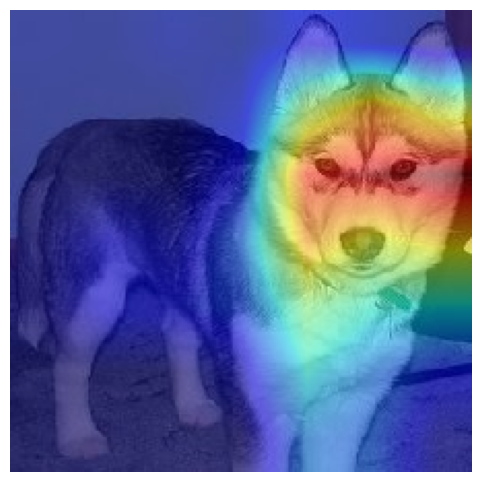

Saved Grad-CAM image to: x_gradcam.png


In [307]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib
import cv2

# Replicate data augmentation from model training for the fusion model
# resnet50
resnet_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
df_single_resnet = pd.DataFrame({'file':[img_path], 'label':[class_name]})
resnet_gen = resnet_datagen.flow_from_dataframe(
    dataframe=df_single_resnet,
    x_col='file',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False,
    batch_size=1
)
#xception
xcep_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)
df_single_xcep = pd.DataFrame({'file':[img_path], 'label':[class_name]})
xcep_gen = xcep_datagen.flow_from_dataframe(
    dataframe=df_single_xcep,
    x_col='file',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False,
    batch_size=1
)

# Get the augmentated and orignal iamges
resnet_img, _ = resnet_gen.next()  
xcep_img, _ = xcep_gen.next()      
img_orig = img_to_array(load_img(img_path, target_size=(224,224)))

# Prediction
pred = fusion_model.predict([resnet_img, xcep_img])
pred_class = np.argmax(pred[0])
print("Predicted class:", pred_class)

# Grad-CAM funciton for the fusion model
# Reference: The following function was partially derived with the assistance of Co-Pilot (GTP-5).
def grad_cam_fusion_both(model, resnet_img, xcep_img, class_index,
                         resnet_last_conv='conv5_block3_out', xcep_last_conv='block14_sepconv2_act'):
    # Get the ResNet branch output predictions
    resnet_model = tf.keras.Model(
        [model.inputs[0], model.inputs[1]],
        [model.get_layer(resnet_last_conv).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = resnet_model([resnet_img, xcep_img])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    weighted = conv_outputs * pooled_grads[tf.newaxis, tf.newaxis, :]
    resnet_heatmap = tf.reduce_sum(weighted, axis=-1).numpy()
    resnet_heatmap = np.maximum(resnet_heatmap, 0)
    resnet_heatmap /= resnet_heatmap.max() + 1e-8

    # Get the Xception branch output predictions
    xcep_model = tf.keras.Model(
        [model.inputs[0], model.inputs[1]],
        [model.get_layer(xcep_last_conv).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = xcep_model([resnet_img, xcep_img])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    weighted = conv_outputs * pooled_grads[tf.newaxis, tf.newaxis, :]
    xcep_heatmap = tf.reduce_sum(weighted, axis=-1).numpy()
    xcep_heatmap = np.maximum(xcep_heatmap, 0)
    xcep_heatmap /= xcep_heatmap.max() + 1e-8

    return resnet_heatmap, xcep_heatmap

# Grad-CAM heatmap overlay on the orignal image
# Reference: The following function was partially derived with the assistance of Co-Pilot (GTP-5).
def display_gradcam(img_orig, heatmap, alpha=0.4, cmap='jet', save_prefix=None):
    # Re-size the heatmap to original image
    heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap_color = matplotlib.colormaps[cmap](heatmap)[..., :3]

    # Normalize original image to [0,1]
    display_img = img_orig.astype(np.float32)
    if display_img.max() > 1.0:
        display_img /= 255.0

    # Blend original image and heatmap
    blended = np.clip((1 - alpha) * display_img + alpha * heatmap_color, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(blended)
    plt.axis('off')
    plt.show()

    # Save the image for comparison
    if save_prefix is not None:
        save_img = (blended * 255).astype(np.uint8)
        save_path = f"{save_prefix}_gradcam.png"
        Image.fromarray(save_img).save(save_path)
        print(f"Saved Grad-CAM image to: {save_path}")

# Create, display, and save heatmap overlay on original image
heatmap = grad_cam_fusion(fusion_model, resnet_img, xcep_img, pred_class)
display_gradcam(img_orig, heatmap, alpha=0.5, save_prefix='x')

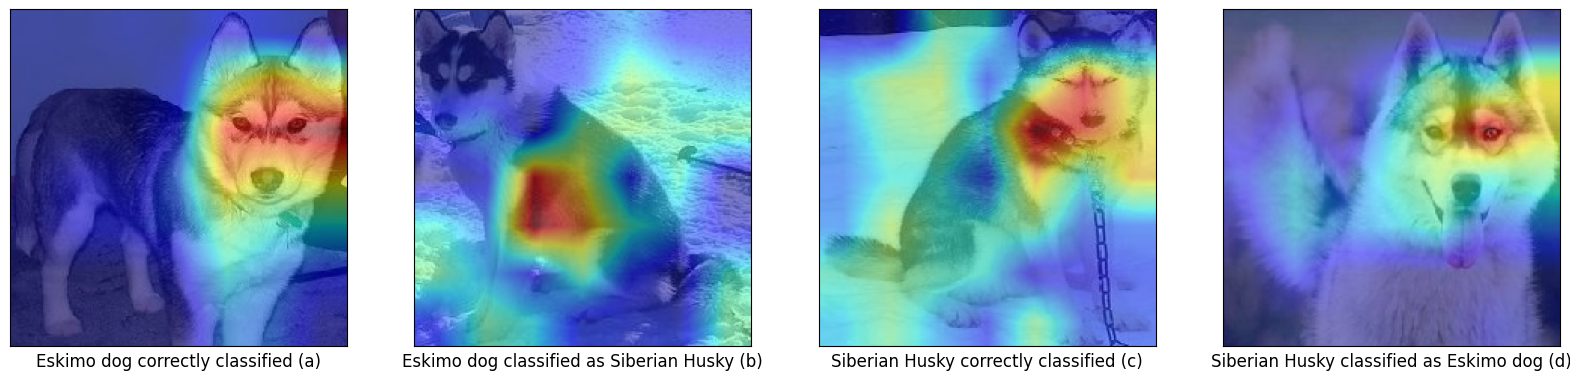

In [311]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Image paths
saved_files = ['eks_cor_gradcam.png', 'eks_inc_gradcam.png', 'sib_cor_gradcam.png', 'sib_inc_gradcam.png']
# Image subtitle
titles = ['Eskimo dog correctly classified', 
          'Eskimo dog classified as Siberian Husky', 
          'Siberian Husky correctly classified', 
          'Siberian Husky classified as Eskimo dog']
labels = ['(a)', '(b)', '(c)', '(d)']

# Load images
images = [np.array(Image.open(f)) for f in saved_files]

# Plot the side-by-side plot
plt.figure(figsize=(20,5))
for i, img in enumerate(images):
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.xlabel(f"{titles[i]} {labels[i]}", fontsize=12)
    plt.xticks([])  
    plt.yticks([]) 

#plt.tight_layout()
plt.savefig('gradcam_comparison.png', dpi=300)
plt.show()